# MPC 

## Involve solving quadratic programs for the future time 

In [6]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

import time, csv, os, requests
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs
    
plt.rcParams.update({"axes.grid" : True})
                     
from scipy import linalg
from numpy import linalg as LA
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

try:
    from tclab import TCLab, clock, Historian, Plotter, setup
except:
    %pip import tclab 
    from tclab import TCLab, clock, Historian, Plotter, setup        

Running Python: 3.8.12


In [7]:
# parameter values and units
T_ambient = 21         # ambient temperature of the surroundings
# 2 options for these parameters founds using the system ID codes 
params = np.array([11.125,    2.321,    0.076,    0.058,    0.077 ]) # optimized via the sys id notebook
params = np.array([13.842,    0.514,    0.080,    0.057,    0.020 ]) # optimized via the sys id notebook
Cp_H, Cp_S, Ua, Ub, Uc = params

P1 = 5.5 #4                 # watts
P2 = 2                 # watts

sfmt = "     {0:5.1f} sec:   T1 = {1:0.1f} C    T2 = {2:0.1f} C"

In [8]:
N = 10 # MPC steps
Nu = 1 # number of actuators usedfor the control
if 1: # constant delta T
    Tf = 120  # MPC plan time
    t_plan = np.linspace(0, Tf, N) # MPC plan time
    Ts = t_plan[1] - t_plan[0] # delta T for the planner
    print(f"Ts = {Ts:.3f} sec")
else: # varying delta T
    Ts = 20
    t_plan = Ts*np.array([0, 1, 2, 3, 4, 5, 6, 8, 10, 12])
    Tf = max(t_plan)  # MPC plan time

Tfsim = Nu*800                # sim end time
delT_sim = Ts/2             # sim Ts
Npts = Tfsim//delT_sim     # number of sim pts

t_prop = np.array([0,delT_sim]) # Time period for a propagation of dynamics for the sim over a short time period

U0 = [0 for i in t_plan] # zero IC
U1 = [1 for i in t_plan] # 1 IC
# setup zero dist for propagation during planning
W0 = interp1d(x = t_plan, y = U0, kind='zero') 
# dist params for sim

Real_Dist = False
if Real_Dist:
    Wmin = 5 
    Wmax = delT_sim # time to arduino in sec for fan on
else:
    Wmin = 0 
    Wmax = 0.1 

if Nu == 2:
    U0 = np.append(U0,U0)
    U1 = np.append(U1,U1)

# Sensing noise
Vmax = 0.25

ref1 = np.array([30, 0])       # refs 
ref2 = np.array([40, 0])       # 
ref3 = np.array([50, 0])       # 

Ts = 13.333 sec


In [9]:
# ODE compute response to an input stream given by U
def deriv(t, T, Nu, Tlim, u1, u2 = 0):
    t = min(t,Tlim)
    if Nu == 1:   # 2 state 1 input used for planner
        T_H1, T_S1 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Uc*(T_S1 - T_H1) + P1*u1(t))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        deltaT = np.array([dT_H1, dT_S1])
    else:  # 4 state 2 input used for sim
        T_H1, T_S1, T_H2, T_S2 = T
        dT_H1 = (Ua*(T_ambient - T_H1) + Ub*(T_H2 - T_H1) + Uc*(T_S1 - T_H1) + P1*u1(t))/Cp_H
        dT_S1 = Uc*(T_H1 - T_S1)/Cp_S
        dT_H2 = (Ua*(T_ambient - T_H2) + Ub*(T_H1 - T_H2) + Uc*(T_S2 - T_H2) + P2*u2(t))/Cp_H
        dT_S2 = Uc*(T_H2 - T_S2)/Cp_S
        deltaT = np.array([dT_H1, dT_S1, dT_H2, dT_S2])   
    return deltaT

# NL Constraint
def cons_f(U):
    return U

nonlinear_constraint = NonlinearConstraint(cons_f, 0, 1) # inequality UB of zero

def cost(U, Nu, x0, Tf, mpc_ref, sen_Noise): # U will be array of future control inputs
    mpc_x0 = x0 + sen_Noise # add some noise to the planner state knowledge
    u1 = U[0::Nu]
    U1plan = interp1d(x = t_plan, y = u1, kind='zero')
    if Nu == 2:
        u2 = U[1::Nu]
        U2plan = interp1d(x = t_plan, y = u2, kind='zero')
        call_args = (Nu,Tf,U1plan,U2plan)
    else:
        call_args = (Nu,Tf,U1plan)

    res1 = solve_ivp(deriv, [0, Tf], mpc_x0, t_eval=t_plan, args=call_args)   # Default values are 1e-3 for rtol and 1e-6 for atol.

    z1 = mpc_ref[0] - res1.y[1]  # T_S1
    delU1 = np.diff(u1)  # penalize delta U not U
    J = z1@z1.T + delU1.T@delU1/10

    if Nu == 2:
        z2 = mpc_ref[1] - res1.y[3] # T_S2 
        delU2 = np.diff(u2)  # penalize delta U not U
        J += delU2.T@delU2/10 + 0.1*z2@z2.T          
    return J

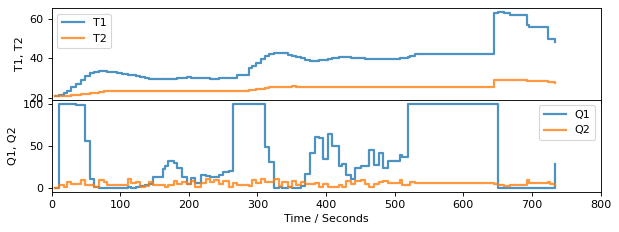

     Disturb = 9.40
     Heater1 = 73.90 %, Heater2 = 9.40 %
     Optim_time = 3.51
     734.0 sec:   T1 = 48.3 C    T2 = 27.4 C


In [ ]:
ref = ref1       # IC for ref input
U = U1           # control IC for start
Ustore = []
Wstore = []
Rstore = []
Tstore=[] 
Xdata = []
opt_success = False
TCLab = setup(connected=False, speedup=1)
with TCLab() as lab:
    # set current state as IC
    T_S1_meas = lab.T1
    T_S2_meas = lab.T2
    X0 = np.array([T_S1_meas, T_S1_meas, T_S2_meas, T_S2_meas])   # propagated state that will be start of next sim

    h = Historian(lab.sources)
    p = Plotter(h, Tfsim,layout=(('T1', 'T2'), ('Q1', 'Q2')))

    prev_time = time.time()
    start_time = prev_time
    while time.time()-start_time <= Tfsim:
        time_delta = time.time()-start_time
        Tstore = np.append(Tstore,time_delta)   
        
        #state = T_H1, T_S1, T_H2, T_S2
        T_S1_meas = lab.T1
        T_S2_meas = lab.T2
        X = np.array([T_S1_meas, T_S1_meas, T_S2_meas, T_S2_meas])   # propagated state that will be start of next sim
        Xdata = np.append(Xdata,np.array([time_delta, T_S1_meas, T_S2_meas]))   # Store meas

        # pick something interesting times to change ref 
        if time_delta >= Nu*500:
            ref = ref3
        elif time_delta >= Nu*250:
            ref = ref2

        # assume number of sens = number of actuators
        V = np.random.uniform(-Vmax,Vmax,2*Nu) # sensing noise added to the planner IC
        if Nu == 1:
            Xinit = X[0:2] # first 2 states
        else:
            Xinit = X # all 4 states
            
        res = minimize(cost, U, tol=1e-3, method = 'trust-constr', constraints=[nonlinear_constraint], args=(Nu,Xinit,Tf,ref,V))
        if res.success == False:
            print('Optimization Failed')
            break

        p.update(time.time()-start_time)
        
        # compute inputs
        U = res.x
        W = np.random.uniform(Wmin,Wmax,1)
        
        if Real_Dist:
            Wstore = np.append(Wstore,W[0])    
            print(f'     Disturb = {W[0]:2.2f}')
            lab.LED(int(W)) # write to the arduino/fan
            if Nu == 2:
                lab.Q2(U[1]*100)
        else:
            print(f'     Disturb = {W[0]*100:2.2f}')
            Wstore = np.append(Wstore,W[0])    
            if Nu == 1:
                lab.Q2(W[0]*100)  # use Q2 as the dist and not being used for control
            else:
                lab.Q2(sat((U[1]+W[0])*100,0,100)) # use Q2 as the dist and not being used for control

        lab.Q1(U[0]*100) # apply first control input 
          
        print(f'     Heater1 = {lab.Q1():2.2f} %, Heater2 = {lab.Q2():2.2f} %')
      
        # store and prepare for next opt
        Ustore = np.append(Ustore,sat(U[0]))    
        if Nu == 1:
            U = np.append(U[1:],0)  # shift and append guess of 0 to end
            Rstore = np.append(Rstore,ref[0])    
        else:
            Ustore = np.append(Ustore,sat(U[1]))    
            U = np.append(U[2:],np.array([0.0,0.0]))  # shift and append guess of 0 to end
            Rstore = np.append(Rstore,ref)    

        # report temperatures for the next tperiod seconds
        print(f'     Optim_time = {time.time()-prev_time:.2f}', flush=True)
        print(sfmt.format(time.time()-start_time, lab.T1, lab.T2), flush=True)
        while (time.time()-prev_time <= delT_sim) and (time.time()-start_time <= Tfsim):  
            time.sleep(0.0001)
        else:
            print(f'     Loop = {time.time()-prev_time:.2f}', flush=True)
            prev_time = time.time()

    else:
        opt_success = True

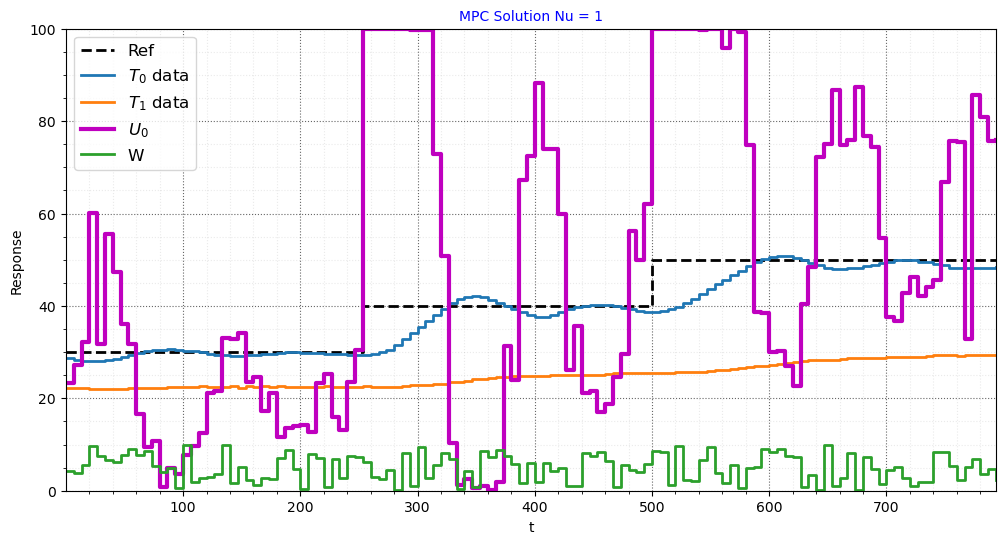

In [6]:
if opt_success:
    t_sim = Tstore #np.linspace(0, Tfsim, int(Npts)) # MPC plan time
    U1sim = interp1d(x = t_sim, y = Ustore[0::Nu], kind='zero')
    if Nu == 1:
        Wsim = interp1d(x = t_sim, y = Wstore, kind='zero')
    else:
        Wsim = interp1d(x = t_sim, y = Wstore + Ustore[1::Nu], kind='zero')
    call_args = (2,Tfsim,U1sim,Wsim) # add in the process noise for the sim
    sim = solve_ivp(deriv, [t_sim[0], t_sim[-1]], X0, t_eval=t_sim, args=call_args)

    plt.figure(figsize = (12,6))
    plt.step(t_sim, Rstore[0::Nu],'k--',label='Ref',where='post')
    plt.step(Xdata[0::3], Xdata[1::3],label=f'$T_0$ data',where='post')
    #plt.plot(t_sim, sim.y[0,:],label='T[0]')
    plt.step(Xdata[0::3], Xdata[2::3],label=f'$T_1$ data',where='post')
    #plt.plot(t_sim, sim.y[1,:],label='T[1]')
    plt.step(t_sim, 100*Ustore[0::Nu],c='m',lw=3,label=f'$U_0$',where='post')
    if Nu == 2:
        plt.step(t_sim, Rstore[1::Nu],'k.',label='Ref',where='post')
        plt.step(t_sim, 100*Ustore[1::Nu],'c.-',lw=3,label=f'$U_1$',where='post')
    plt.step(t_sim, 100*Wstore,label='W',where='post')
    plt.xlabel('t')
    plt.ylabel('Response')
    plt.legend()
    plt.legend(fontsize=12)

    plt.title('MPC Solution Nu = '+str(Nu))
    plt.xlim([min(t_sim),max(t_sim)])
    plt.ylim([0,100])
    nicegrid()
    plt.savefig("figs/TCLAB_NLMPC_"+str(int(time.time()))+".png")